# Exercise 1 $\newcommand{\R}{\mathbb R}$ $\newcommand{\scal}[2]{\left\langle #1,#2 \right\rangle}$ $\newcommand{\norm}[2][]{\Vert #2 \Vert_{#1}}$ $\newcommand{\spImg}{\R^{n_x\times n_y\times3}}$ $\newcommand{\spDImg}{\R^{n_x\times n_y\times3\times2}}$ $\newcommand{\linA}{\mathcal A}$ $\newcommand{\linD}{\mathcal D}$

## TV Denoising

In this exercise we will consider the image denoising problem with TV (total variation) regularization. That is, given a noisy color image $f\in\spImg$, our goal is to recover the denoised image which is achieved by solving
$$ \min_{u \in \spImg} \frac{1}{2} \norm[2]{u - f}^2 + \lambda\norm[F,1]{\linD u} \,, $$
with $\lambda>0$ as the regularization parameter. In the above problem, $\norm[2]{\cdot}:\spImg\to\R$, $\norm[F,1]{\cdot}:\spDImg\to\R$ and $ D:\spImg\to\spDImg $ are respectively defined by:
$$
\begin{align}
    \norm[2]{u}:=&\ \Big(\sum_{i,j,c} u_{i,j,c}^2 \Big)^{1/2} \qquad &(L_2\; \text{norm}) \\
    \norm[F,1]{p}:=&\ \sum_{i,j} \norm[F]{p_{i,j}} &(L_{F,1}\; \text{norm}) \\
    (\linD u)_{i,j}:=&\ \begin{bmatrix} u_{i+1,j,1}-u_{i,j,1} & u_{i,j+1,1}-u_{i,j,1} \\ u_{i+1,j,2}-u_{i,j,2} & u_{i,j+1,2}-u_{i,j,2} \\ u_{i+1,j,3}-u_{i,j,3} & u_{i,j+1,3}-u_{i,j,3} \end{bmatrix}, \quad (i,j) \in [n_x]\times[n_y] &\text{(Derivative Operator)} \,,
\end{align}
$$
where $p_{i,j}$ refers to the block of coordinate associated to pixel $i,j$:
$$ p_{i,j} := \begin{bmatrix} p_{i,j,1,1} & p_{i,j,1,2} \\ p_{i,j,2,1} & p_{i,j,2,2} \\ p_{i,j,3,1} & p_{i,j,3,2} \end{bmatrix} \,. $$
We define $[n]:=\{1,\dots,n\}$ and use Neumann boundary conditions, i.e., $u_{n_x+1,j,c}:=u_{n_x,j,c}$ and $u_{i,n_y+1,c}:=u_{i,n_y,c}$ for all $i,j,c$.

### Fenchel-Rockafellar Dual
One may try to solve the above optimization problem by Forward-Backward Splitting (FBS) method, however that can be a real challenge. We instead apply FBS to its Fenchel-Rockafellar dual.

#### Task 1 - Derive the Fenchel-Rockafellar dual of the given problem. (4 points)

*Remove this line and write down your answer here*

In [1]:
#Import some useful packages. You can import scipy.sparse if required.
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

### Implementing the Derivative Operator $\linD$

We first implement the Derivative operator and its adjoint as python functions. This can be done in two ways.
* Either, you implement both the derivative and its adjoint operator, the way they are given. For example, let $ \linA:\R^{2\times2}\to\R^2 $ be some operator defined by $ \begin{bmatrix} x_{1,1} & x_{1,2} \\ x_{2,1} & x_{2,2} \end{bmatrix}=:X\mapsto \linA X := (x_{1,1} + x_{1,2}, x_{2,1} - x_{2,2}) $. Then you can simply return *np.array([X[0,0]+X[0,1], X[1,0]-X[1,1]])* for any input *X* which is a numpy array. You can compute its adjoint $ \linA^*:\R^2\to\R^{2\times2} $ by using the idenity $\scal{\linA X}{X} = \scal{X}{\linA^*x}$ which comes out to be $ (x_1, x_2)=:x\mapsto \linA^*x := \begin{bmatrix} x_1 & x_1 \\ x_2 & x_2 \end{bmatrix} $. This can be implemented as *return np.array([[x[0], x[0]], [x[1], x[1]]])* with input *x*. Avoid using for loops for efficiency.
* Or, you can find the matrix representation of the derivative operator and store it as a numpy array. You can then convert the input tensor to a vector, perform matrix-vector multiplication and convert the resulting vector back to the appropriate tensor. For adjoint operation, you do the same but with matrix transpose. For example, for implementing $\linA$ defined above, we convert the input matrix $X\in\R^{2\times2}$ to a vector $ (x_{1,1}, x_{1,2}, x_{2,1}, x_{2,2})\in\R^4 $ and multiply it by the matrix:$$A = \begin{bmatrix} 1 & 1 & 0 & 0 \\ 0 & 0 & 1 & 1 \end{bmatrix}\,,$$which gives us the desired output. For implementing $\linA^*$ with given input $x$, we compute $A^Tx =:(y_1, y_2, y_3, y_4) \in \R^4$ and then convert it to a matrix $\begin{bmatrix} y_1 & y_2 \\ y_3 & y_4 \end{bmatrix}$ in $\R^{2\times2}$. Use sparse matrix storage, transpose and multiplication from *scipy.sparse* for efficiency.

#### Task 2 - Implement the derivative and its adjoint. (6 + 6 = 12 points)

In [2]:
def derivative(u):
    """
    Input:
        u - an nx x ny x 3 tensor.
    
    Output
        p - an nx x ny x 3 x 2 tensor.
    """
    nx, ny, _ = u.shape
    p = np.zeros((nx, ny, 3, 2))
    
    # Forward differences along x-axis
    p[:-1, :, :, 0] = u[1:, :, :] - u[:-1, :, :]
    p[-1, :, :, 0] = u[-1, :, :] - u[-2, :, :] 
    
    # Forward differences along y-axis
    p[:, :-1, :, 1] = u[:, 1:, :] - u[:, :-1, :]
    p[:, -1, :, 1] = u[:, -1, :] - u[:, -2, :]  
    
    return p

def derivative_adjoint(p):
    """
    Input:
        p - an nx x ny x 3 x 2 tensor.
        
    Output
        u - an nx x ny x 3 tensor.
    """
    nx, ny, _ = p.shape[:3]
    u = np.zeros((nx, ny, 3))
    
    # Backward differences along x-axis
    u[1:, :, :] += p[:-1, :, :, 0]
    u[:-1, :, :] -= p[:-1, :, :, 0]
    u[0, :, :] -= p[0, :, :, 0] 
    
    # Backward differences along y-axis
    u[:, 1:, :] += p[:, :-1, :, 1]
    u[:, :-1, :] -= p[:, :-1, :, 1]
    u[:, 0, :] -= p[:, 0, :, 1]  
    
    return u

### Implementing the Dual Objective
We implement the objective of the dual problem as a python function.

#### Task 3 - Implement the objective function. (2 points).

In [3]:
def objective(p, f, reg):
    """
    Dual objective: -0.5 * ||div(p)||^2 + <div(p), f>
    """
    div_p = derivative_adjoint(p)  
    inner_product = np.sum(div_p * f)
    norm_div_p_sq = np.sum(div_p ** 2)
    
    obj = -0.5 * norm_div_p_sq + inner_product
    return obj

### Implementing the Gradient
We implement the gradient of the smooth component of the dual objective with respect to $p$ as a python function.

#### Task 4 - Implement the gradient. (2 points).

In [4]:
def gradient(p, f, reg):
    """
    Inputs:
        p - an nx x ny x 3 x 2 tensor.
        f - an nx x ny x 3 tensor (the noisy image).
        reg - a non-negative scalar (the regularization parameter).
    
    Output:
        grad - an nx x ny x 3 x 2 tensor (the gradient of the smooth component).
    """
    div_p = primal(p)
    return derivative(div_p + f)

### Implementing the Proximal Operator
We implement the proximal mapping of the non-smooth component of the dual objective as a python function.

#### Task 5 - Implement the proximal operator. (4 points).

In [5]:
def proximal(p):
    """
    Inputs:
        p - an nx x ny x 3 x 2 tensor.
    
    Output:
        prox - an nx x ny x 3 x 2 tensor (the proximal mapping of the non-smooth component).
    """
    norm = np.linalg.norm(p, axis=-1, keepdims=True)
    norm_safe = np.maximum(norm, 1e-8) 
    return np.where(norm > reg, p * (reg / norm_safe), p)

### Primal Solution from the Dual Solution
We now extract the primal solution from the dual solution.

#### Task 6 - Complete the code for computing the primal solution. (2 points)

In [6]:
def primal(p):
    nx, ny, _ = p.shape[:3]
    u = np.zeros((nx, ny, 3))
    
    # Divergence along x-axis
    u[:-1, :, :] += p[:-1, :, :, 0]
    u[1:, :, :] -= p[:-1, :, :, 0]
    
    # Divergence along y-axis
    u[:, :-1, :] += p[:, :-1, :, 1]
    u[:, 1:, :] -= p[:, :-1, :, 1]
    
    return -u

### Implementing the Algorithm
We are now ready to implement our algorithm. A crude implementation for FBS is given below. You are required to add the following things to the code.

#### Task 7 - Compute the Lipschitz constant of the smooth part of the objective. (4 points)

#### Task 8 - After every disp iterations, display the current iterate. (You should make use of *primal* function above to obtain the primal iterate from the dual and display that.) (4 points)

#### Task 9 - Modify the code to add acceleration in it. (4 points)

You may need to track the objective value and adjust the *maxiters* variable.

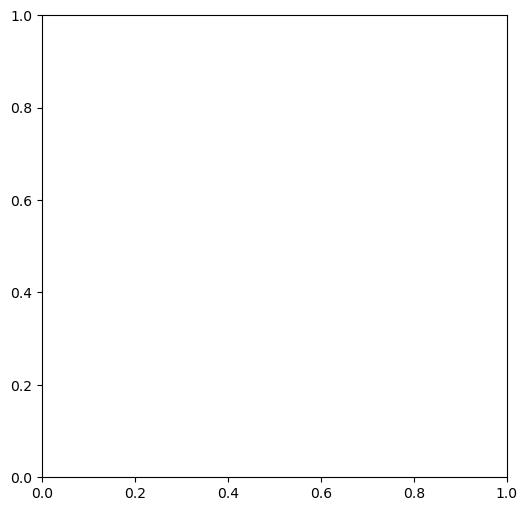

In [7]:
lip_const = 8.0
stepsize = 1 / lip_const
maxiters = 250
disp = 25

plt.ion()
fig, ax = plt.subplots(figsize=[6, 6])

def FBS(f, reg):
    pk = derivative(f)
    yk = pk.copy()
    tk = 1

    for k in range(maxiters):
        grad = gradient(yk, f, reg)
        pk_next = proximal(yk - stepsize * grad)

        tk_next = (1 + np.sqrt(1 + 4 * tk**2)) / 2
        yk = pk_next + ((tk - 1) / tk_next) * (pk_next - pk)

        pk = pk_next
        tk = tk_next

        if k % disp == 0 and k > 0:
            u = primal(pk)
            print(f"[iter {k}] u.min = {u.min():.4f}, u.max = {u.max():.4f}")
            ax.clear()
            ax.imshow(np.clip(u, 0, 1))
            ax.set_title(f"Iteration {k}")
            ax.axis('off')
            plt.pause(0.1)

    plt.ioff()
    plt.show()
    return primal(pk)

### Denoising the  Image
We take a clean image and add some Gaussian noise to it and try to denoise it by TV denoising. In order to do that we need to find the best value of the regularization parameter $\lambda$. If it is too small, noise will not be removed properly. If it is too big, the image will be blurry.

#### Task 10 - Find the best possible value of the regularization parameter. (2 points)

Running FBS with reg = 0.1
[iter 25] u.min = -0.3414, u.max = 0.3414
[iter 50] u.min = -0.3414, u.max = 0.3414
[iter 75] u.min = -0.3414, u.max = 0.3414
[iter 100] u.min = -0.3414, u.max = 0.3414
[iter 125] u.min = -0.3414, u.max = 0.3414
[iter 150] u.min = -0.3414, u.max = 0.3414
[iter 175] u.min = -0.3414, u.max = 0.3414
[iter 200] u.min = -0.3414, u.max = 0.3414
[iter 225] u.min = -0.3414, u.max = 0.3414
Running FBS with reg = 0.5
[iter 25] u.min = -0.8253, u.max = 0.8489
[iter 50] u.min = -0.8220, u.max = 0.8499
[iter 75] u.min = -0.7942, u.max = 0.8491
[iter 100] u.min = -0.7904, u.max = 0.8426
[iter 125] u.min = -0.7929, u.max = 0.8375
[iter 150] u.min = -0.7889, u.max = 0.8324
[iter 175] u.min = -0.7895, u.max = 0.8303
[iter 200] u.min = -0.7899, u.max = 0.8302
[iter 225] u.min = -0.7897, u.max = 0.8296
Running FBS with reg = 1
[iter 25] u.min = -0.8300, u.max = 0.8489
[iter 50] u.min = -0.8218, u.max = 0.8499
[iter 75] u.min = -0.7934, u.max = 0.8494
[iter 100] u.min = -0.7554,

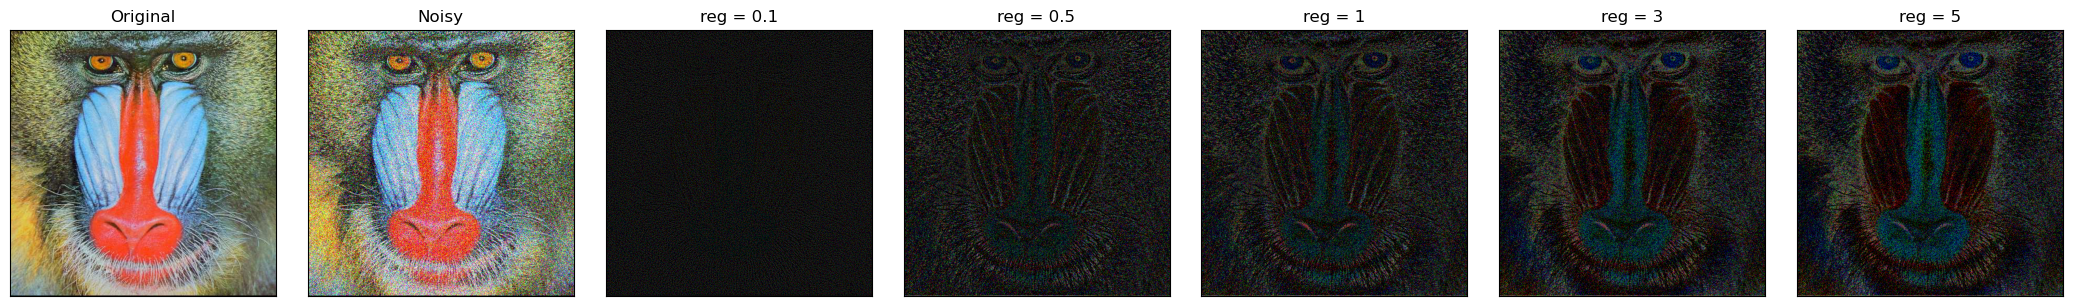

In [8]:
original = np.asarray(PIL.Image.open("baboon.png")) / 255.
clip = lambda img: np.maximum(np.minimum(img, 1), 0)
np.random.seed(42)
noisy = clip(original + 0.25 * np.random.randn(*original.shape))

reg_list = [0.1, 0.5, 1, 3, 5]
results = []

for reg in reg_list:
    print(f"Running FBS with reg = {reg}")
    denoised = FBS(noisy, reg)
    results.append((reg, denoised))

cols = len(results) + 2
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(3 * cols, 3))

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(noisy)
ax[1].set_title("Noisy")

for i, (reg, denoised) in enumerate(results):
    ax[i + 2].imshow(np.clip(denoised, 0, 1))
    ax[i + 2].set_title(f"reg = {reg}")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()